# Assignment 1
## Team : Tensor Tamers
### Members: Dharmi Gala | Naman | Kshitij | Vishal Parameswaran

Mandatory Installations

Using LakeFs client v0.113.0.1 to match lakeFS server 0.113.0

In [33]:
# %pip install 'lakefs-client==0.113.0.1' -q
# %pip install "tensorflow==2.14" -q
# %pip install "tensorflow-privacy" -q

In [34]:
import pandas as pd
import numpy as np
import configparser
import seaborn as sns
import matplotlib.pyplot as plt

#LakeFS Imports
import lakefs_client
from lakefs_client import models
from lakefs_client.client import LakeFSClient
from lakefs_client.api import actions_api

In [35]:
config = configparser.ConfigParser()
config.read('CONFIG/config.ini')
key = config['LAKEFS']['key']
secret = config['LAKEFS']['secret']

Creating the LakeFS client and connecting to server

In [36]:
lakefs_config = lakefs_client.Configuration()
lakefs_config.username = key
lakefs_config.password = secret
lakefs_config.host = '127.0.0.1:8000'

lakefs = LakeFSClient(lakefs_config)

Lets test the connection

In [37]:
lakefs.repositories.list_repositories()

{'pagination': {'has_more': False,
                'max_per_page': 1000,
                'next_offset': '',
                'results': 0},
 'results': []}

Lets make a repository called mlops-tensor-tamers to track our data.

In [38]:
repo = 'mlops-tensor-tamers'
branch = 'main'
fileName = "athletes.csv"
filePath = "../data/athletes.csv"

In [39]:
repo = models.RepositoryCreation(name=repo, storage_namespace='local://', default_branch=branch)
lakefs.repositories_api.create_repository(repo)

{'creation_date': 1697706032,
 'default_branch': 'main',
 'id': 'mlops-tensor-tamers',
 'storage_namespace': 'local://'}

In [40]:
storage_namespace = repo.storage_namespace
repo_id = repo.name
branch = repo.default_branch

Let us upload our data to lakefs

In [41]:
contentToUpload = open(f"{filePath}", 'rb')
lakefs.objects.upload_object(repository=repo_id, branch=branch, path=f'data/{fileName}', content=contentToUpload)

{'checksum': 'ade8057a9ad4350dfade9180f021a96d',
 'content_type': 'application/vnd.ms-excel',
 'mtime': 1697706034,
 'path': 'data/athletes.csv',
 'path_type': 'object',
 'physical_address': 'local:///home/lakefs/lakefs/data/block/data/gkf160nnjpms739saf1g/ckof0cfnjpms739saf2g',
 'size_bytes': 71546909}

Lets look at our diffs

In [42]:
lakefs.branches.diff_branch(repository=repo_id, branch=branch).results

[{'path': 'data/athletes.csv',
  'path_type': 'object',
  'size_bytes': 71546909,
  'type': 'added'}]

Lets commit our data to the repository

In [43]:
lakefs.commits.commit(
    repository=repo_id,
    branch=branch,
    commit_creation=models.CommitCreation(message='Added Athletes.csv | Version: 1', metadata={'using': 'python_api'}))

{'committer': 'quickstart',
 'creation_date': 1697706034,
 'id': '310d2ab981e87705d1db36a70329c43b22c6659db1a5501c96423e33f6fd22d2',
 'message': 'Added Athletes.csv | Version: 1',
 'meta_range_id': '',
 'metadata': {'using': 'python_api'},
 'parents': ['b98c5625ebac43870103451c1f3b6ea1332ecffa360491b21af0b365ce2683cd']}

Lets use the main branch to store the original code. We can make newer branches when we make changes. As we will have to track commit ID's to track changes in our code, it makes more sense to create branches when we make changes

Lets read from LakeFs | This is version 1 of the data

In [44]:
data = lakefs.objects.get_object(repository=repo_id, ref=branch, path=f'data/{fileName}')
df = pd.read_csv(data)
df.head()

,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,...,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,...,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,...,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,...,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


## EDA V1

Lets explore the data.

In [45]:
df.columns

Index(['athlete_id', 'name', 'region', 'team', 'affiliate', 'gender', 'age',
       'height', 'weight', 'fran', 'helen', 'grace', 'filthy50', 'fgonebad',
       'run400', 'run5k', 'candj', 'snatch', 'deadlift', 'backsq', 'pullups',
       'eat', 'train', 'background', 'experience', 'schedule', 'howlong'],
      dtype='object')

In [46]:
df.describe()

,athlete_id,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,candj,snatch,deadlift,backsq,pullups
count,423003.000000,331110.000000,1.598690e+05,229890.000000,5.542600e+04,3.027900e+04,4.074500e+04,1.935900e+04,2.973800e+04,2.224600e+04,3.609700e+04,1.044350e+05,9.728000e+04,1.153230e+05,1.105170e+05,5.060800e+04
mean,292748.166538,32.516750,1.206217e+02,170.896137,9.886691e+02,1.207950e+03,5.766025e+02,2.127863e+03,1.472252e+03,5.241279e+02,3.411464e+03,2.709107e+02,2.424957e+02,6.970503e+02,5.852109e+02,4.269613e+04
std,184969.660327,7.730671,2.097995e+04,58.379799,7.200430e+04,6.824091e+04,4.891145e+04,6.055021e+04,9.762688e+04,5.628804e+04,1.251980e+05,2.596882e+04,2.708942e+04,5.523235e+04,5.052976e+04,9.546078e+06
min,82.000000,13.000000,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,-6.000000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-4.500000e+01,0.000000e+00,-5.000000e+02,-7.000000e+00,-6.000000e+00
25%,135091.500000,27.000000,6.600000e+01,145.000000,2.150000e+02,5.250000e+02,1.490000e+02,1.308000e+03,2.400000e+02,6.200000e+01,1.242000e+03,1.400000e+02,1.050000e+02,2.550000e+02,2.050000e+02,1.500000e+01
50%,275839.000000,31.000000,6.900000e+01,170.000000,2.900000e+02,5.950000e+02,1.930000e+02,1.550000e+03,2.940000e+02,7.100000e+01,1.380000e+03,1.950000e+02,1.450000e+02,3.450000e+02,2.750000e+02,2.700000e+01
75%,473188.000000,37.000000,7.200000e+01,192.000000,3.920000e+02,6.940000e+02,2.620000e+02,1.809000e+03,3.360000e+02,8.400000e+01,1.560000e+03,2.350000e+02,1.850000e+02,4.150000e+02,3.350000e+02,3.900000e+01
max,633083.000000,125.000000,8.388607e+06,20175.000000,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,2.147484e+09


Lets get columns that are non number.

In [47]:
df_num = df.select_dtypes(exclude=[np.number])
df_num

,name,region,team,affiliate,gender,eat,train,background,experience,schedule,howlong
0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,Derek Abdella,NaN,NaN,NaN,Male,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,Bryce Abbey,NaN,NaN,NaN,Male,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|
...,...,...,...,...,...,...,...,...,...,...,...
423001,Odo Renata,Latin America,Team Guarujá Inox,CrossFit Guaruja,Female,NaN,NaN,NaN,NaN,NaN,NaN
423002,Lozzie Trevor,Australia,FBP CrossFit Games Team,FBP CrossFit,Female,NaN,NaN,NaN,NaN,NaN,NaN
423003,Marisol Smith,North West,CrossFit Oak Harbor,CrossFit Oak Harbor,Female,NaN,NaN,NaN,NaN,NaN,NaN
423004,Pedrini Morgane,Europe,NaN,CrossFit 67,Female,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|,NaN,I began CrossFit with a coach (e.g. at an affi...,I usually only do 1 workout a day|I strictly s...,6-12 months|


We can see that the name and athlete_id column does not contribute any value to the model and is a breach of PPI, so we will be dropping it.

In [48]:
df = df.drop(columns=['name','athlete_id'])

Lets take a look at the unique values in the other text columns:

In [49]:
#regenerate the columns with only string data
df_num = df.select_dtypes(exclude=[np.number])

for column in df_num.columns:
    print("---"*30)
    print(f"column name: {column}")
    print(df[column].unique())
    print("Number of unique values: ", len(df[column].unique()))

------------------------------------------------------------------------------------------
column name: region
['South West' nan 'Southern California' 'South Central' 'Central East'
 'Europe' 'North East' 'Africa' 'South East' 'Australia'
 'Northern California' 'Latin America' 'Canada East' 'North Central'
 'North West' 'Mid Atlantic' 'Canada West' 'Asia']
Number of unique values:  18
------------------------------------------------------------------------------------------
column name: team
['Double Edge' nan 'LAX CrossFit' ... 'CrossFit AC' 'BLACK SHEEP'
 'CrossFit DV8']
Number of unique values:  4533
------------------------------------------------------------------------------------------
column name: affiliate
['Double Edge CrossFit' nan 'LAX CrossFit' ... 'Black and Gold CrossFit'
 'Reebok CrossFit Gurgaon' 'CrossFit Shardana']
Number of unique values:  9779
------------------------------------------------------------------------------------------
column name: gender
['Male' nan 

It is clear that the columns: Howlong, schedule, experience, background, train and eat are MCQ questions. We should identify the individual values and create dummies.

But before we procees any further, we should remove all nans to make the process easier.

In [50]:
df = df.dropna(subset=df_num.columns)

This is a pseudo dummies method, as the various options are split by |

In [51]:
def generate_dummies(df,columns):
    for column in columns:
        columns = pd.unique(df[column].str.split("|", expand=True).stack())
        columns = [column + '_' + x for x in columns if x != '']
        dfs = df[column].str.get_dummies(sep='|').reindex(columns, axis=1, fill_value=0).astype(bool)
        df = pd.concat([df, dfs], axis=1)
        df.drop(columns = [column], axis=1, inplace=True)
    return df

Lets drop the team and affiliate columns as they have way too many unique columns.

In [52]:
df = df.drop(columns=['team','affiliate'])

Lets generate dummies for region and gender

In [53]:
df = pd.get_dummies(df,columns=['region','gender'],dtype=bool)

In [54]:
df.drop(columns=['gender_--'], inplace=True)

Now that we're done with the basics, lets generate the dummies for the aforementioned columns

In [55]:
df = generate_dummies(df,["howlong", "schedule", "experience", "background", "train", "eat"])

We should calculate the totalLift score

In [56]:
df['total_lift'] = df['candj'] + df['snatch'] + df['deadlift'] + df['backsq']

Lets drop the rows, where total_lift is nan

In [57]:
df = df.dropna(subset=['total_lift'])

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24093 entries, 3 to 422961
Data columns (total 75 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   age                                                                  24093 non-null  float64
 1   height                                                               23358 non-null  float64
 2   weight                                                               21954 non-null  float64
 3   fran                                                                 14174 non-null  float64
 4   helen                                                                8752 non-null   float64
 5   grace                                                                11502 non-null  float64
 6   filthy50                                                             5724 non-null   float64
 7   fgo

I consider this version to be the actual baseline version we can make a model on, as the basic data cleaning has been completed. Lets create a new branch called cleaned_main and commit the data to it.

In [59]:
df.to_csv('../data/athletes.csv', index=False)

In [60]:
branch = "cleaned_main"
lakefs.branches.create_branch(repo_id, models.BranchCreation(name=branch,source='main'))
contentToUpload = open(f"{filePath}", 'rb')
lakefs.objects.upload_object(repository=repo_id, branch=branch, path=f'data/{fileName}', content=contentToUpload)
lakefs.commits.commit(
    repository=repo_id,
    branch=branch,
    commit_creation=models.CommitCreation(message='cleaned main Athletes.csv | Version: 1.1', metadata={'using': 'python_api','changes':'cleaned data'}))

{'committer': 'quickstart',
 'creation_date': 1697706038,
 'id': '47f1e55aae8ce84feb69ecd33ca5f454b96ef970ef6429b372628cf7b175d04a',
 'message': 'cleaned main Athletes.csv | Version: 1.1',
 'meta_range_id': '',
 'metadata': {'changes': 'cleaned data', 'using': 'python_api'},
 'parents': ['310d2ab981e87705d1db36a70329c43b22c6659db1a5501c96423e33f6fd22d2']}

### We will be using the brain cleaned main to refer to Version 1 for modelling.

### Let us now clean the data further

In [61]:
data = lakefs.objects.get_object(repository=repo_id, ref=branch, path=f'data/{fileName}')
df = pd.read_csv(data)
df.head()

,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,...,"train_I workout mostly at home, work, or a traditional gym",train_I write my own programming,train_Decline to answer,eat_I eat 1-3 full cheat meals per week,eat_I eat quality foods but don't measure the amount,eat_I eat whatever is convenient,eat_I eat strict Paleo,eat_I weigh and measure my food,eat_Decline to answer,total_lift
0,40.0,67.0,NaN,211.0,645.0,300.0,NaN,196.0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,1145.0
1,21.0,72.0,175.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,0.0
2,43.0,71.0,185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,0.0
3,30.0,71.0,200.0,243.0,NaN,164.0,NaN,298.0,NaN,1584.0,...,False,False,False,False,False,False,False,False,False,1110.0
4,28.0,70.0,176.0,720.0,680.0,NaN,NaN,280.0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,910.0


Lets take a look at the numerical columns

In [62]:
df_num = df.select_dtypes(exclude=[bool])
df_num

,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,candj,snatch,deadlift,backsq,pullups,total_lift
0,40.0,67.0,NaN,211.0,645.0,300.0,NaN,196.0,NaN,NaN,245.0,200.0,375.0,325.0,25.0,1145.0
1,21.0,72.0,175.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,43.0,71.0,185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,30.0,71.0,200.0,243.0,NaN,164.0,NaN,298.0,NaN,1584.0,235.0,175.0,385.0,315.0,35.0,1110.0
4,28.0,70.0,176.0,720.0,680.0,NaN,NaN,280.0,NaN,NaN,187.0,134.0,335.0,254.0,27.0,910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24088,39.0,75.0,186.0,980.0,NaN,NaN,NaN,NaN,NaN,NaN,145.0,85.0,245.0,135.0,NaN,610.0
24089,24.0,70.0,174.0,NaN,NaN,NaN,NaN,NaN,NaN,1059.0,143.0,121.0,351.0,287.0,12.0,902.0
24090,25.0,64.0,126.0,659.0,796.0,NaN,2443.0,NaN,NaN,NaN,110.0,88.0,243.0,176.0,12.0,617.0
24091,22.0,72.0,174.0,NaN,NaN,345.0,NaN,NaN,NaN,NaN,115.0,95.0,175.0,115.0,NaN,500.0


Lets remove nulls from the dataset

In [63]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24093 entries, 0 to 24092
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         24093 non-null  float64
 1   height      23358 non-null  float64
 2   weight      21954 non-null  float64
 3   fran        14174 non-null  float64
 4   helen       8752 non-null   float64
 5   grace       11502 non-null  float64
 6   filthy50    5724 non-null   float64
 7   fgonebad    8731 non-null   float64
 8   run400      6532 non-null   float64
 9   run5k       8899 non-null   float64
 10  candj       24093 non-null  float64
 11  snatch      24093 non-null  float64
 12  deadlift    24093 non-null  float64
 13  backsq      24093 non-null  float64
 14  pullups     13084 non-null  float64
 15  total_lift  24093 non-null  float64
dtypes: float64(16)
memory usage: 2.9 MB


We can see that columns like fran helen filthy50 fgonebad run400 have too few values to impute. so we drop them, We can also remove nulls from the rest and impute values for grace and run5k

In [64]:
df = df.drop(columns=['filthy50','fgonebad','run400','helen'])

In [65]:
df_num = df.select_dtypes(exclude=[bool])
df_num

,age,height,weight,fran,grace,run5k,candj,snatch,deadlift,backsq,pullups,total_lift
0,40.0,67.0,NaN,211.0,300.0,NaN,245.0,200.0,375.0,325.0,25.0,1145.0
1,21.0,72.0,175.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,43.0,71.0,185.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,30.0,71.0,200.0,243.0,164.0,1584.0,235.0,175.0,385.0,315.0,35.0,1110.0
4,28.0,70.0,176.0,720.0,NaN,NaN,187.0,134.0,335.0,254.0,27.0,910.0
...,...,...,...,...,...,...,...,...,...,...,...,...
24088,39.0,75.0,186.0,980.0,NaN,NaN,145.0,85.0,245.0,135.0,NaN,610.0
24089,24.0,70.0,174.0,NaN,NaN,1059.0,143.0,121.0,351.0,287.0,12.0,902.0
24090,25.0,64.0,126.0,659.0,NaN,NaN,110.0,88.0,243.0,176.0,12.0,617.0
24091,22.0,72.0,174.0,NaN,345.0,NaN,115.0,95.0,175.0,115.0,NaN,500.0


Lets take a look at the box plots to identify outliers etc.

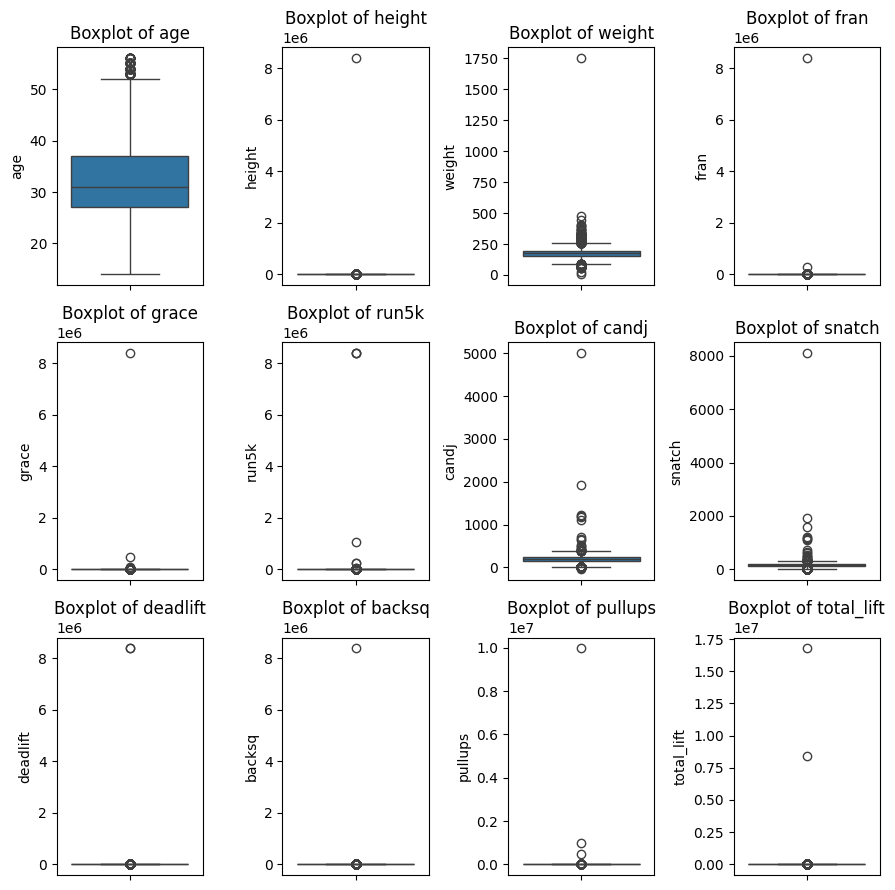

In [66]:
fig, axes = plt.subplots(3, 4, figsize=(9, 9))
axes = axes.ravel()
for i, feature in enumerate(df_num.columns):
    sns.boxplot(y=df[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

We can clearly see that for
1.  Any age above 50 is an outlier, ages <18 should also be removed
2.  Any height above 100, seems to be wrong.
3.  Any weight above 250 should be removed and treated as an outlier
4.  Any fran above 1000
5.  Any helen above 1000
6.  Any grace above 219
7.  Any filthy50 above 1652
8.  Any fgonebad above 400
9.  Any run400 above 1000
10. Any run5k above 1459
11. Any candj above 450.
12. Any snatch above 450
13. Any deadlift above 700
14. Any backsq above 700
15. Any pullups above 490

In [67]:
# Remove Outliers
df = df[((df['age'] < 50) & (df['age'] > 18)) | (df['age'].isna())]
df = df[((df['height'] < 80) & (df['height']>60)) | (df['height'].isna())]
df = df[((df['weight'] < 500) & (df['weight'] > 100))  | (df['weight'].isna())]
df = df[(df['fran'] < 800) | (df['fran'].isna())]
df = df[(df['grace'] < 1000) | (df['grace'].isna())]
df = df[((df['run5k'] < 2000) & (df['run5k'] > 1000)) | (df['run5k'].isna())]
df = df[((df['candj'] < 400) & (df['candj']  > 0))  | (df['candj'].isna())]
df = df[(df['snatch'] < 400)  | (df['snatch'].isna())]
df = df[((df['deadlift'] < 1000) & (df['deadlift']>0))  | (df['height'].isna())]
df = df[((df['backsq'] < 700) & (df['backsq'] > 0))  | (df['backsq'].isna())]
df = df[(df['pullups'] < 90)  | (df['pullups'].isna())]

lets review the box plots again

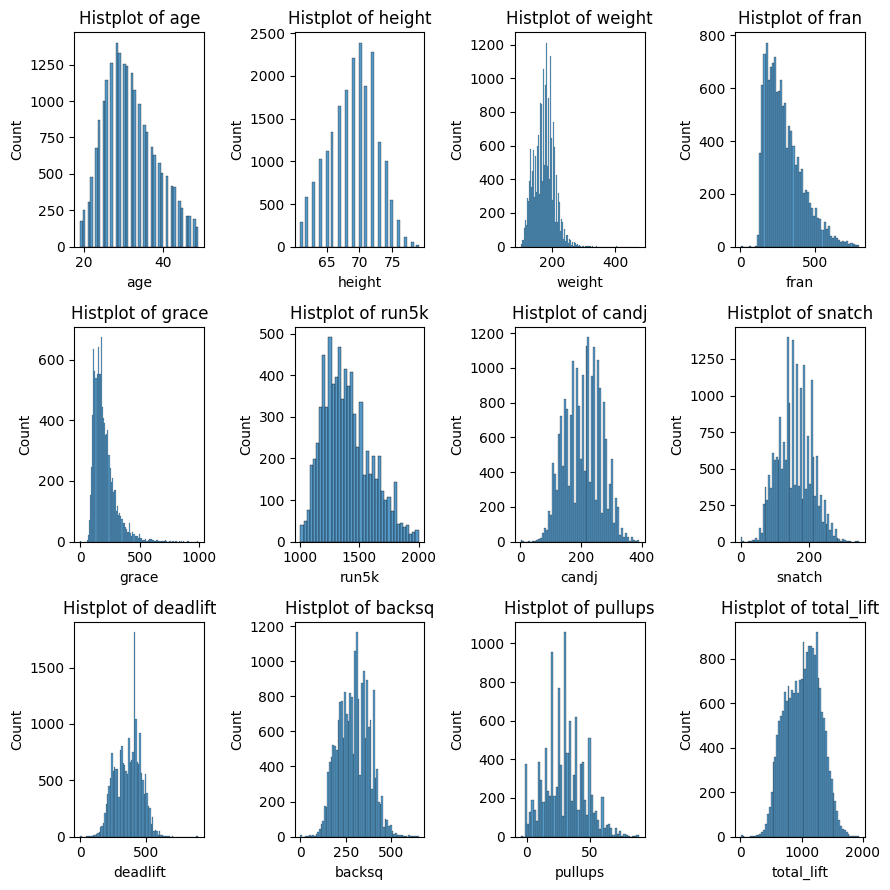

In [68]:
fig, axes = plt.subplots(3, 4, figsize=(9, 9))
axes = axes.ravel()
for i, feature in enumerate(df_num.columns):
    sns.histplot(df[feature], ax=axes[i])
    axes[i].set_title(f'Histplot of {feature}')

plt.tight_layout()
plt.show()

It seems that all the outliers are taken care of now.

Let us impute the values for the columns now.

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21299 entries, 0 to 24091
Data columns (total 71 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   age                                                                  21299 non-null  float64
 1   height                                                               20641 non-null  float64
 2   weight                                                               19434 non-null  float64
 3   fran                                                                 13017 non-null  float64
 4   grace                                                                10621 non-null  float64
 5   run5k                                                                7908 non-null   float64
 6   candj                                                                21299 non-null  float64
 7   snat

Let us now impute the values

In [70]:
df[df_num.columns] = df[df_num.columns].fillna(df[df_num.columns].mean())

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21299 entries, 0 to 24091
Data columns (total 71 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   age                                                                  21299 non-null  float64
 1   height                                                               21299 non-null  float64
 2   weight                                                               21299 non-null  float64
 3   fran                                                                 21299 non-null  float64
 4   grace                                                                21299 non-null  float64
 5   run5k                                                                21299 non-null  float64
 6   candj                                                                21299 non-null  float64
 7   snat

Lets check the correlation of the variables
First lets check the numerical columns

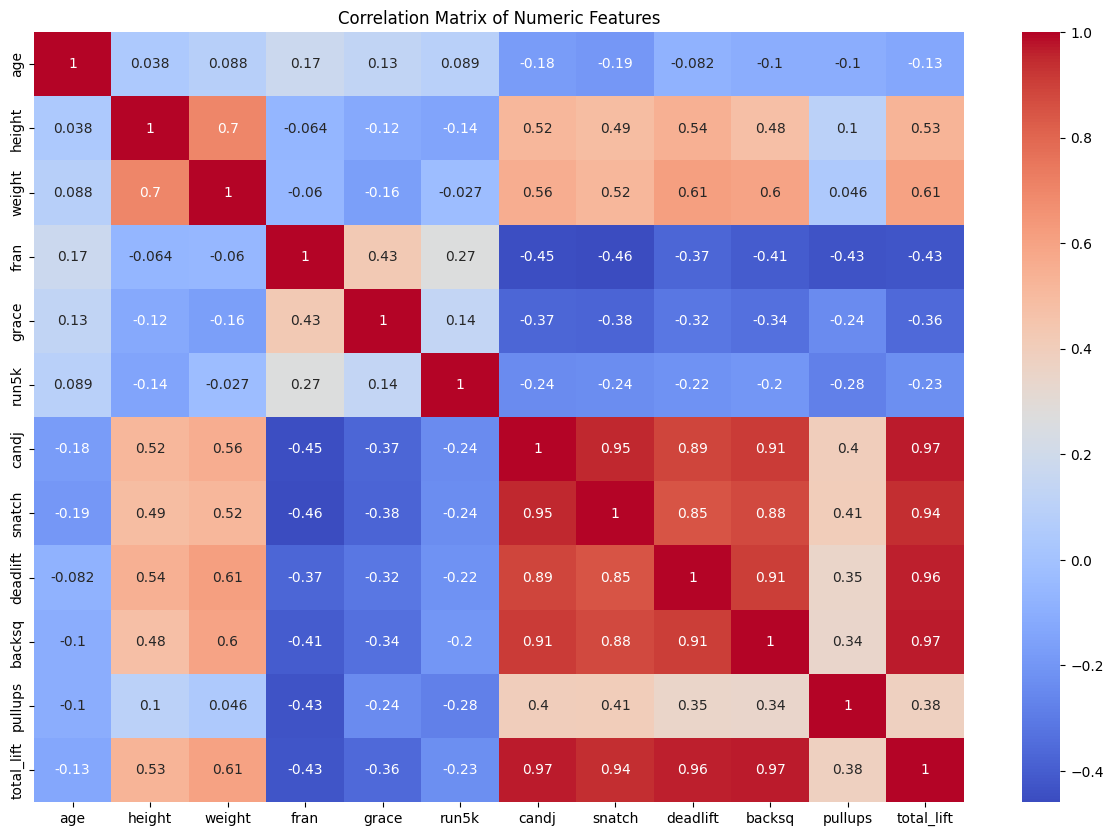

In [72]:
corr_matrix = df.select_dtypes(exclude=[object,bool]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

Because the total_lift column is built off of candj,snatch,deadlift ad backsp, it would be wise to address it later on.

### Storing the Data

Lets commit our data to the branch cleaned_complete

In [73]:
df.to_csv('../data/athletes.csv', index=False)

In [74]:
branch = "cleaned_complete"
lakefs.branches.create_branch(repository=repo_id, branch_creation=models.BranchCreation(name=branch,source="cleaned_main"))
contentToUpload = open(file=f"{filePath}", mode='rb')
lakefs.objects.upload_object(repository=repo_id, branch=branch, path=f'data/{fileName}', content=contentToUpload)
lakefs.commits.commit(
    repository=repo_id,
    branch=branch,
    commit_creation=models.CommitCreation(message='cleaned data and features extraction Athletes.csv | Version: 2', metadata={'using': 'python_api','changes':'features extraced'}))

{'committer': 'quickstart',
 'creation_date': 1697706042,
 'id': 'e88f4e6a9c64331e25090aaf0b7f41b1bc4eaf108ae291507144cbd42932a35d',
 'message': 'cleaned data and features extraction Athletes.csv | Version: 2',
 'meta_range_id': '',
 'metadata': {'changes': 'features extraced', 'using': 'python_api'},
 'parents': ['47f1e55aae8ce84feb69ecd33ca5f454b96ef970ef6429b372628cf7b175d04a']}

## Data Modelling

lets work on modelling our data now.

In [75]:
#convert boolean columns to int
def convert_bool(df):
    for column in df.columns:
        if df[column].dtype == bool:
            df[column] = df[column].astype(int)
    return df

In [76]:
# Mandatory Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt

Let us make a pipeline, through which we will process the data

To handle a dataset with nans, lets use a model and a scaler that accepts nans

In [77]:
pipe = Pipeline([
  ('normalization', StandardScaler()), # Scale and standardize the data
  # ('feature_selection', SelectFromModel(LinearSVR(loss='epsilon_insensitive', epsilon=0))), # Select features we want to use
  ('Regression', XGBRegressor()) # Use XGBoost to train the model
])

### Using Data from V1

Lets convert the data into train and test sets

In [78]:
import gc
gc.collect()

16583

In [79]:
branch="cleaned_main"
data = lakefs.objects.get_object(repository=repo_id, ref=branch, path=f'data/{fileName}')
df = pd.read_csv(filepath_or_buffer=data)
df.head()

,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,...,"train_I workout mostly at home, work, or a traditional gym",train_I write my own programming,train_Decline to answer,eat_I eat 1-3 full cheat meals per week,eat_I eat quality foods but don't measure the amount,eat_I eat whatever is convenient,eat_I eat strict Paleo,eat_I weigh and measure my food,eat_Decline to answer,total_lift
0,40.0,67.0,NaN,211.0,645.0,300.0,NaN,196.0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,1145.0
1,21.0,72.0,175.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,0.0
2,43.0,71.0,185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,0.0
3,30.0,71.0,200.0,243.0,NaN,164.0,NaN,298.0,NaN,1584.0,...,False,False,False,False,False,False,False,False,False,1110.0
4,28.0,70.0,176.0,720.0,680.0,NaN,NaN,280.0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,910.0


The data contains nans, so we should either impute or delete them.

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24093 entries, 0 to 24092
Data columns (total 75 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   age                                                                  24093 non-null  float64
 1   height                                                               23358 non-null  float64
 2   weight                                                               21954 non-null  float64
 3   fran                                                                 14174 non-null  float64
 4   helen                                                                8752 non-null   float64
 5   grace                                                                11502 non-null  float64
 6   filthy50                                                             5724 non-null   float64
 7   fgon

In [81]:
df_num_list = [x for x in df_num.columns if x!="total_lift"]
df_num_list

['age',
 'height',
 'weight',
 'fran',
 'grace',
 'run5k',
 'candj',
 'snatch',
 'deadlift',
 'backsq',
 'pullups']

In [82]:
df = convert_bool(df=df)

Lets split the data

In [83]:
X_train, X_test , y_train, Y_test = train_test_split(df.drop(columns=['total_lift']), df['total_lift'], test_size=0.2, random_state=42)

In [84]:
X_train.shape

(19274, 74)

Lets train the model and evaluate it.

In [85]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mae_v1 = mean_absolute_error(Y_test, y_pred)
mse_v1 = mean_squared_error(Y_test, y_pred)
r2_v1 = r2_score(Y_test, y_pred)

print(f"Mean Absolute Error (MAE) for v1: {mae_v1:.4f}")
print(f"Root Mean Squared Error (RMSE) for v1: {sqrt(mse_v1):.4f}")
print(f"R^2 Score for v1: {r2_v1:.4f}")

Mean Absolute Error (MAE) for v1: 2216.8377
Root Mean Squared Error (RMSE) for v1: 153259.6461
R^2 Score for v1: -211701.8913


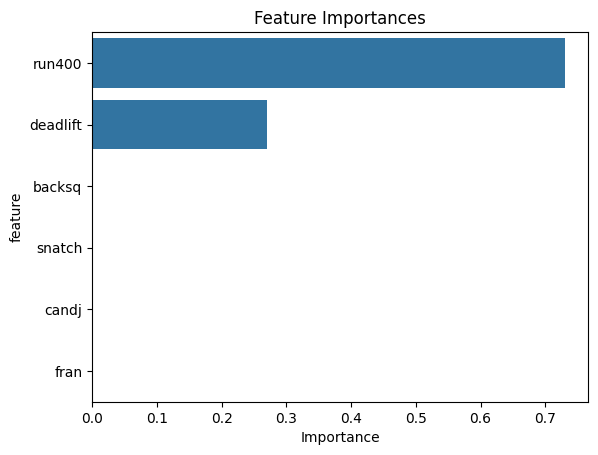

In [86]:
importances = pipe.steps[1][1].feature_importances_
importance_series = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)[:6]
# importance_series.index
sns.barplot(x = importance_series, y= importance_series.index)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("feature")
plt.show()

This model is clearly not a good model, as the $r^{2}$ is clearly negative. More work has to be done to impute nans and remove outliers

## Using Data V2

In [87]:
import gc
gc.collect()

35381

In [88]:
branch="cleaned_complete"
data = lakefs.objects.get_object(repository=repo_id, ref=branch, path=f'data/{fileName}')
df = pd.read_csv(filepath_or_buffer=data)
df.head()

,age,height,weight,fran,grace,run5k,candj,snatch,deadlift,backsq,...,"train_I workout mostly at home, work, or a traditional gym",train_I write my own programming,train_Decline to answer,eat_I eat 1-3 full cheat meals per week,eat_I eat quality foods but don't measure the amount,eat_I eat whatever is convenient,eat_I eat strict Paleo,eat_I weigh and measure my food,eat_Decline to answer,total_lift
0,40.0,67.0,177.723629,211.0,300.000000,1394.510749,245.0,200.0,375.0,325.0,...,False,False,False,False,False,False,False,False,False,1145.0
1,30.0,71.0,200.000000,243.0,164.000000,1584.000000,235.0,175.0,385.0,315.0,...,False,False,False,False,False,False,False,False,False,1110.0
2,28.0,70.0,176.000000,720.0,201.749929,1394.510749,187.0,134.0,335.0,254.0,...,False,False,False,False,False,False,False,False,False,910.0
3,35.0,68.0,225.000000,215.0,112.000000,1394.510749,285.0,205.0,440.0,405.0,...,False,False,False,False,False,False,False,False,False,1335.0
4,36.0,71.0,199.000000,284.0,154.000000,1394.510749,267.0,212.0,485.0,390.0,...,False,False,False,False,False,False,False,False,False,1354.0


In [89]:
df = convert_bool(df=df)

In [90]:
X_train, X_test , y_train, Y_test = train_test_split(df.drop(columns=['total_lift']), df['total_lift'], test_size=0.2, random_state=42)

In [91]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mae_v2 = mean_absolute_error(Y_test, y_pred)
mse_v2 = mean_squared_error(Y_test, y_pred)
r2_v2 = r2_score(Y_test, y_pred)

print(f"Mean Absolute Error (MAE) for v2: {mae_v2:.4f}")
print(f"Root Mean Squared Error (RMSE) for v2: {sqrt(mse_v2):.4f}")
print(f"R^2 Score for v2: {r2_v2:.4f}")

Mean Absolute Error (MAE) for v2: 6.2506
Root Mean Squared Error (RMSE) for v2: 9.1866
R^2 Score for v2: 0.9989


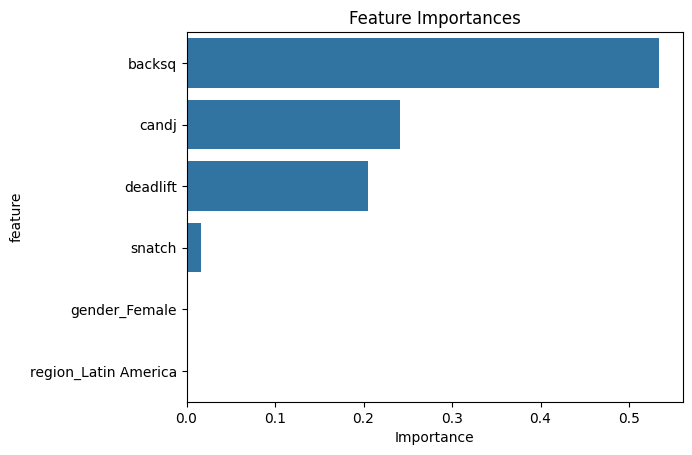

In [92]:
importances = pipe.steps[1][1].feature_importances_
importance_series = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)[:6]
# importance_series.index
sns.barplot(x = importance_series, y= importance_series.index)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("feature")
plt.show()

As we can see, this model is much better, but it might be overfitting. This is because the model has clearly identified the relationship between Total_Lift and BackSQ, C&j,Deadlift and Snatch

## Testing Tensorflows Differential Privacy

In [93]:
import tensorflow as tf
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy import compute_dp_sgd_privacy_statement
from tensorflow_privacy.privacy.optimizers import dp_optimizer_keras
import datetime
import os

Lets take a look at the $\epsilon$ value for our Dataset V2

In [94]:
len(X_train)

17039

In [132]:
l2_norm_clip = 0.5
noise_multiplier = 1.3
num_microbatches = 1
learning_rate = 2e-3
number_of_examples = len(X_train)
batch_size = 50
epochs=100
delta=1e-5


print(compute_dp_sgd_privacy(n=number_of_examples,
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=delta))

(2.131641070005613, 10.0)


In [133]:

print(compute_dp_sgd_privacy_statement(number_of_examples=number_of_examples,
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              num_epochs=epochs,
                                              delta=delta))

DP-SGD performed over 17039 examples with 50 examples per iteration, noise
multiplier 1.3 for 100 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:       189.882
    Epsilon assuming Poisson sampling (*):                      9.552

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed the actual epsilon should be
closer to this value than the conservative assumption of an arbitrary data
order.



We can see that with a poisson value of 4.322, the model has a decent DP value

## Let us train a TF NN model to test

In [101]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [126]:
from keras.src.layers.preprocessing import normalization
optimizer = dp_optimizer_keras.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# Select your loss function
# loss = tf.keras.losses.mean_squared_error()

normalization = tf.keras.layers.Normalization(axis=-1)
normalization.adapt(np.array(X_train))

model = tf.keras.Sequential([
    tf.keras.layers.Input((70,)),
    normalization,
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(1)
])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
metrics = [tf.keras.metrics.MeanSquaredError(),
           tf.keras.metrics.RootMeanSquaredError(),
           tf.keras.metrics.R2Score(),
           tf.keras.metrics.MeanAbsoluteError()]

In [127]:
class model_per_epoch(tf.keras.callbacks.Callback):
    def __init__(self, model,filepath,save_best_only):
        self.filepath=filepath
        self.model=model
        self.save_best_only=save_best_only
        self.lowest_loss=np.inf
        self.best_weights=self.model.get_weights()
    def on_epoch_end(self,epoch, logs=None):
        v_loss=logs.get('val_loss')
        if v_loss< self.lowest_loss:
            self.lowest_loss =v_loss
            self.best_weights=self.model.get_weights()
            self.best_epoch=epoch +1
        if self.save_best_only==False:
            name= str(epoch) +'-' + str(v_loss)[:str(v_loss).rfind('.')+3] + '.h5'
            file_id=os.path.join(self.filepath, name)
            self.model.save(file_id)
    def on_train_end(self, logs=None):
        if self.save_best_only == True:
            self.model.set_weights(self.best_weights)
            name= str(self.best_epoch) +'-' + str(self.lowest_loss)[:str(self.lowest_loss).rfind('.')+3] + '.h5'
            file_id=os.path.join(self.filepath, name)
            self.model.save(file_id)
            print(' model is returned with best weights from epoch ', self.best_epoch)
            
save_dir=r'models/'
save_best_only= True

In [128]:
# Compile your model
model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=metrics)
# Fit your model
model.fit(X_train, y_train,
  epochs=epochs,
  validation_data=(X_test, Y_test),
  batch_size=batch_size,
  callbacks=[tensorboard_callback,model_per_epoch(model, save_dir, save_best_only)])

Epoch 1/100
  1/341 [..............................] - ETA: 4:55 - loss: 1251032.0000 - mean_squared_error: 1251032.0000 - root_mean_squared_error: 1118.4954 - r2_score: -12.8106 - mean_absolute_error: 1077.2556WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_train_batch_end` time: 0.0054s). Check your callbacks.


341/341 [==============================] - 2s 2ms/step - loss: 1124930.2500 - mean_squared_error: 1124930.2500 - root_mean_squared_error: 1060.6273 - r2_score: -13.2865 - mean_absolute_error: 1022.8250 - val_loss: 1111676.0000 - val_mean_squared_error: 1111676.0000 - val_root_mean_squared_error: 1054.3605 - val_r2_score: -13.8511 - val_mean_absolute_error: 1018.2419
Epoch 2/100
341/341 [==============================] - 1s 2ms/step - loss: 1121748.5000 - mean_squared_error: 1121748.5000 - root_mean_squared_error: 1059.1263 - r2_score: -13.2459 - mean_absolute_error: 1021.3009 - val_loss: 1108411.2500 - val_mean_squared_error: 1108411.2500 - val_root_mean_squared_error: 1052.8112 - val_r2_score: -13.8075 - val_mean_absolute_error: 1016.6863
Epoch 3/100
341/341 [==============================] - 1s 2ms/step - loss: 1118666.6250 - mean_squared_error: 1118666.6250 - root_mean_squared_error: 1057.6704 - r2_score: -13.2069 - mean_absolute_error: 1019.8508 - val_loss: 1105230.5000 - val_mean_

c:\Users\yomaa\.conda\envs\mlops2\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [129]:
y_pred = model.predict(X_test)
mae_tf = mean_absolute_error(Y_test, y_pred)
mse_tf = mean_squared_error(Y_test, y_pred)
r2_tf = r2_score(Y_test, y_pred)

print(f"Mean Absolute Error (MAE) for tf: {mae_tf:.4f}")
print(f"Root Mean Squared Error (RMSE) for tf: {sqrt(mse_tf):.4f}")
print(f"R^2 Score for tf: {r2_tf:.4f}")

134/134 [==============================] - 0s 628us/step
Mean Absolute Error (MAE) for tf: 132.6327
Root Mean Squared Error (RMSE) for tf: 177.2324
R^2 Score for tf: 0.5804


In [130]:
results = pd.DataFrame(columns=["Run","MAE","RMSE","R2"],data=[["Dataset_V1",mae_v1,sqrt(mse_v1),r2_v1],["Dataset_V2",mae_v2,sqrt(mse_v2),r2_v2],["Tensorflow DP",mae_tf,sqrt(mse_tf),r2_tf]])
results

,Run,MAE,RMSE,R2
0,Dataset_V1,2216.837749,153259.646149,-211701.891345
1,Dataset_V2,6.250572,9.186585,0.998873
2,Tensorflow DP,132.632714,177.232382,0.580370
